# Encode IVAR of SDSS spectra

In [1]:
import os, sys 
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.nn import functional as F

In [2]:
import corner as DFM 
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
seed = 0 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [4]:
device

device(type='cuda', index=0)

# 1. Load measured uncertainties for SDSS Spectra
We'll be using `ivar` the inverse variance measurements. We'll trim out any measurements where ivar = 0 and z < 0.1

In [5]:
# read in SDSS spectra
dat_dir = '/scratch/network/chhahn/sedflow/spectra/'
rawspec = np.load(os.path.join(dat_dir, 'sdss_spectra.100000.npz')) # SDSS dr16 spectra

In [6]:
bad_ivar = (np.sum(rawspec['ivar'], axis=1) == 0)
print(f'{np.sum(bad_ivar)} have bad IVAR values')
zlim = (rawspec['z'] < 0.1) 
print(f'{np.sum(zlim)} have z < 0.1')

cuts = zlim & ~bad_ivar

758 have bad IVAR values
46580 have z < 0.1


In [7]:
wave = 10**rawspec['wave']
spec = rawspec['spectra'][cuts]
ivar = rawspec['ivar'][cuts]
mask = rawspec['mask'][cuts]
zred = rawspec['z'][cuts]

In [8]:
nwave = len(wave)
print(f'{nwave} spectral elements')

3892 spectral elements


Text(0, 0.5, 'IVAR')

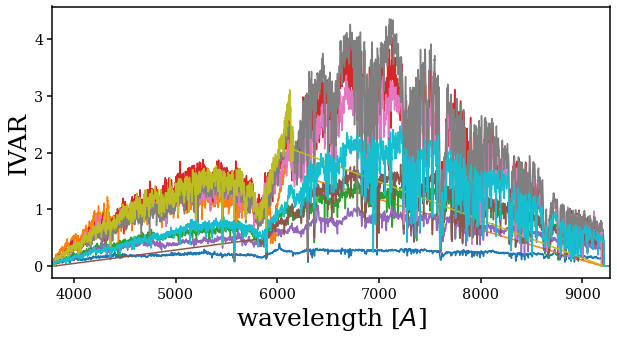

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in range(10): 
    sub.plot(wave[~mask[100*i]], ivar[100*i][~mask[100*i]])
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(wave[0], wave[-1])
sub.set_ylabel('IVAR', fontsize=25)

# 2. normalize and whiten ivar measurements
Before we can train an autoencoder, we probably want to normalize and whiten the data. As you can see in the figure above, the IVAR span a very broad range of amplitudes. 

The normalization factor can be one of the compressed variables

In [10]:
ivar_zero = (ivar == 0)
ivar_norm = np.array([np.median(i[~m & ~iz]) for i, m, iz in zip(ivar, mask, ivar_zero)])

In [11]:
avg_ivar = np.array([np.mean(i[~m & ~iz]) for i, m, iz in zip((ivar / ivar_norm[:,None]).T, mask.T, ivar_zero.T)])
std_ivar = np.array([np.std(i[~m & ~iz]) for i, m, iz in zip((ivar / ivar_norm[:,None]).T, mask.T, ivar_zero.T)])

# last spectral element has no ivar
avg_ivar[-1] = 0. 
std_ivar[-1] = 1.

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
w_ivar = ((ivar / ivar_norm[:,None]) - avg_ivar[None,:])/std_ivar[None,:]

Text(0, 0.5, 'whitened IVAR')

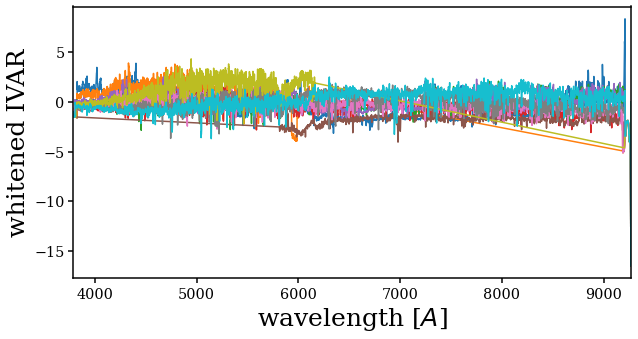

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in range(10): 
    sub.plot(wave[~mask[100*i]], w_ivar[100*i][~mask[100*i]])
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(wave[0], wave[-1])
sub.set_ylabel('whitened IVAR', fontsize=25)

# 3. Train Autoencoder

In [14]:
batch_size = 2048

ntrain = int(0.8 * ivar.shape[0])
nvalid = int(0.1 * ivar.shape[0])
print(f'Ntrain = {ntrain}; Nvalid = {nvalid}')

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(w_ivar[:ntrain,:][:,None,:], dtype=torch.float32),
        torch.tensor(mask[:ntrain,:], dtype=torch.bool)),
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(w_ivar[ntrain:ntrain+nvalid,:][:,None,:], dtype=torch.float32), 
        torch.tensor(mask[ntrain:ntrain+nvalid,:], dtype=torch.bool)),
    batch_size=batch_size)

Ntrain = 36981; Nvalid = 4622


In [15]:
class InfoVAE(nn.Module):
    def __init__(self, nwave=1000, ncode=5, alpha=0, lambd=10000, 
                 nkernels=[3, 3, 3], nhiddens_enc=[128, 64, 32], nhiddens_dec=[128, 64, 32], npools=[2, 2, 2], 
                 dropout=0.2):
        super(InfoVAE, self).__init__()
        
        self.ncode = int(ncode)
        self.alpha = float(alpha)
        self.lambd = float(lambd)

        nkernel0, nkernel1, nkernel2 = nkernels
        nhidden0_enc, nhidden1_enc, nhidden2_enc = nhiddens_enc
        nhidden0_dec, nhidden1_dec, nhidden2_dec = nhiddens_enc
        npool0, npool1, npool2 = npools

        # convolutional layers
        self.conv0 = nn.Conv1d(1, 1, kernel_size=nkernel0)
        Lout = nwave - nkernel0 + 1 
        self.p0 = nn.MaxPool1d(npool0)
        Lout = int((Lout - npool0)/npool0 + 1)
        self.conv1 = nn.Conv1d(1, 1, kernel_size=nkernel1)
        Lout = Lout - nkernel1 + 1 
        self.p1 = nn.MaxPool1d(npool1)
        Lout = int((Lout - npool1)/npool1 + 1)
        self.conv2 = nn.Conv1d(1, 1, kernel_size=nkernel2)
        Lout = Lout - nkernel2 + 1 
        self.p2 = nn.MaxPool1d(npool2)
        Lout = int((Lout - npool2)/npool2 + 1)

        # encoders
        self.enc0 = nn.Linear(Lout, nhidden0_enc)
        self.d1 = nn.Dropout(p=dropout)
        self.enc1 = nn.Linear(nhidden0_enc, nhidden1_enc)
        self.d2 = nn.Dropout(p=dropout)
        self.enc2 = nn.Linear(nhidden1_enc, nhidden2_enc)
        self.d3 = nn.Dropout(p=dropout)

        self.mu = nn.Linear(nhidden2_enc, ncode)
        self.lv = nn.Linear(nhidden2_enc, ncode)
        
        # decoders
        self.decd = nn.Linear(ncode, nhidden2_dec)
        self.d3 = nn.Dropout(p=dropout)
        self.decd2 = nn.Linear(nhidden2_dec, nhidden1_dec)
        self.d4 = nn.Dropout(p=dropout)
        self.decd3 = nn.Linear(nhidden1_dec, nhidden0_dec)
        self.d5 = nn.Dropout(p=dropout)
        self.outp = nn.Linear(nhidden0_dec, nwave)
        
    def encode(self, x):
        x = self.p0(F.relu(self.conv0(x)))
        x = self.p1(F.relu(self.conv1(x)))
        x = self.p2(F.relu(self.conv2(x)))
        x = self.d1(F.leaky_relu(self.enc0(x)))
        x = self.d2(F.leaky_relu(self.enc1(x)))
        x = self.d3(F.leaky_relu(self.enc2(x)))

        mu = self.mu(x)
        logvar = self.lv(x)
        return mu[:,0,:], logvar[:,0,:]
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, x):
        x = self.d3(F.leaky_relu(self.decd(x)))
        x = self.d4(F.leaky_relu(self.decd2(x)))
        x = self.d5(F.leaky_relu(self.decd3(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        # The example code divides by (dim) here, making <kernel_input> ~ 1/dim
        # excluding (dim) makes <kernel_input> ~ 1
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)#/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size)
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_mmd(self, x, y):
        xx_kernel = self.compute_kernel(x,x)
        yy_kernel = self.compute_kernel(y,y)
        xy_kernel = self.compute_kernel(x,y)
        return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)
    
    def loss(self, x, mask):
        recon_x, mu, logvar = self.forward(x)

        MSE = torch.sum(0.5 * ((x[:,0,:] - recon_x)[~mask]).pow(2))
        
        # KL divergence (Kingma and Welling, https://arxiv.org/abs/1312.6114, Appendix B)
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #return MSE + self.beta*KLD, MSE
                
        # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
        device = x.device
        true_samples = Variable(torch.randn(200, self.ncode), requires_grad=False)
        true_samples = true_samples.to(device)

        z = self.reparameterize(mu, logvar) #duplicate call
        z = z.to(device)
        # compute MMD ~ 1, so upweight to match KLD which is ~ n_batch x n_code
        MMD = self.compute_mmd(true_samples,z) * x.size(0) * self.ncode
        return MSE + (1-self.alpha)*KLD + (self.lambd+self.alpha-1)*MMD, MSE, KLD, MMD

In [16]:
lr = 1e-3
n_epoch = 1000
nlatent = 5
dropout = 0

--- decoder [(1518, 319, 41)] ---
--- encoder [(607, 548, 8)] ---
====> Epoch: 0 TRAINING Loss: 2.15e+03 VALIDATION Loss: 2.20e+03
====> Epoch: 20 TRAINING Loss: 1.86e+03 VALIDATION Loss: 1.91e+03
====> Epoch: 40 TRAINING Loss: 1.84e+03 VALIDATION Loss: 1.89e+03
====> Epoch: 60 TRAINING Loss: 1.78e+03 VALIDATION Loss: 1.71e+03
====> Epoch: 80 TRAINING Loss: 9.95e+02 VALIDATION Loss: 1.04e+03
====> Epoch: 100 TRAINING Loss: 8.70e+02 VALIDATION Loss: 8.98e+02
====> Epoch: 120 TRAINING Loss: 7.59e+02 VALIDATION Loss: 7.86e+02
====> Epoch: 140 TRAINING Loss: 7.23e+02 VALIDATION Loss: 7.46e+02
====> Epoch: 160 TRAINING Loss: 6.91e+02 VALIDATION Loss: 7.20e+02
====> Epoch: 180 TRAINING Loss: 6.62e+02 VALIDATION Loss: 7.15e+02
====> Epoch: 200 TRAINING Loss: 6.58e+02 VALIDATION Loss: 6.83e+02
====> Epoch: 220 TRAINING Loss: 6.55e+02 VALIDATION Loss: 6.97e+02


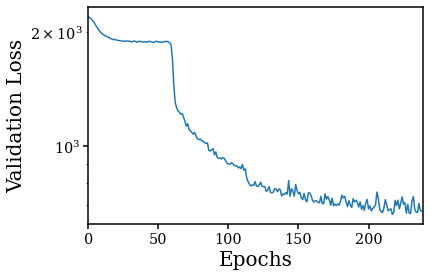

--- decoder [(1950, 1353, 252)] ---
--- encoder [(450, 94, 13)] ---
====> Epoch: 0 TRAINING Loss: 2.14e+03 VALIDATION Loss: 2.18e+03
====> Epoch: 20 TRAINING Loss: 1.94e+03 VALIDATION Loss: 1.98e+03
====> Epoch: 40 TRAINING Loss: 1.84e+03 VALIDATION Loss: 1.90e+03
====> Epoch: 60 TRAINING Loss: 1.84e+03 VALIDATION Loss: 1.89e+03
====> Epoch: 80 TRAINING Loss: 1.83e+03 VALIDATION Loss: 1.88e+03
====> Epoch: 100 TRAINING Loss: 1.83e+03 VALIDATION Loss: 1.88e+03


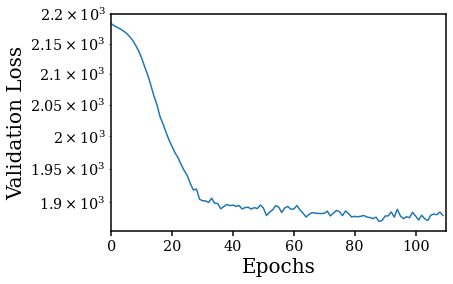

--- decoder [(536, 203, 10)] ---
--- encoder [(113, 49, 8)] ---
====> Epoch: 0 TRAINING Loss: 2.67e+03 VALIDATION Loss: 2.85e+03
====> Epoch: 20 TRAINING Loss: 2.52e+03 VALIDATION Loss: 2.63e+03
====> Epoch: 40 TRAINING Loss: 2.23e+03 VALIDATION Loss: 2.16e+03
====> Epoch: 60 TRAINING Loss: 2.04e+03 VALIDATION Loss: 2.03e+03
====> Epoch: 80 TRAINING Loss: 2.00e+03 VALIDATION Loss: 2.07e+03
====> Epoch: 100 TRAINING Loss: 1.99e+03 VALIDATION Loss: 2.09e+03


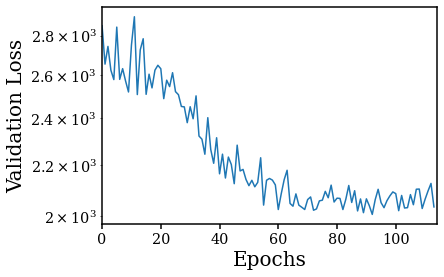

--- decoder [(540, 163, 16)] ---
--- encoder [(891, 30, 11)] ---
====> Epoch: 0 TRAINING Loss: 2.14e+03 VALIDATION Loss: 2.19e+03
====> Epoch: 20 TRAINING Loss: 1.95e+03 VALIDATION Loss: 2.00e+03
====> Epoch: 40 TRAINING Loss: 1.84e+03 VALIDATION Loss: 1.90e+03
====> Epoch: 60 TRAINING Loss: 1.83e+03 VALIDATION Loss: 1.88e+03
====> Epoch: 80 TRAINING Loss: 9.73e+02 VALIDATION Loss: 1.01e+03
====> Epoch: 100 TRAINING Loss: 7.44e+02 VALIDATION Loss: 7.56e+02
====> Epoch: 120 TRAINING Loss: 6.97e+02 VALIDATION Loss: 7.16e+02
====> Epoch: 140 TRAINING Loss: 6.83e+02 VALIDATION Loss: 7.11e+02
====> Epoch: 160 TRAINING Loss: 6.74e+02 VALIDATION Loss: 6.83e+02
====> Epoch: 180 TRAINING Loss: 6.57e+02 VALIDATION Loss: 6.92e+02
====> Epoch: 200 TRAINING Loss: 6.51e+02 VALIDATION Loss: 6.92e+02
====> Epoch: 220 TRAINING Loss: 6.49e+02 VALIDATION Loss: 6.88e+02
====> Epoch: 240 TRAINING Loss: 6.31e+02 VALIDATION Loss: 6.70e+02


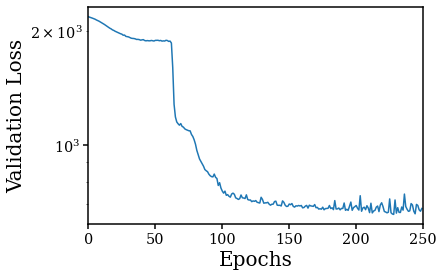

--- decoder [(6570, 2610, 47)] ---
--- encoder [(111, 32, 9)] ---
====> Epoch: 0 TRAINING Loss: 3.52e+03 VALIDATION Loss: 3.84e+03
====> Epoch: 20 TRAINING Loss: 2.89e+03 VALIDATION Loss: 2.82e+03
====> Epoch: 40 TRAINING Loss: 2.65e+03 VALIDATION Loss: 2.68e+03
====> Epoch: 60 TRAINING Loss: 2.42e+03 VALIDATION Loss: 2.46e+03
====> Epoch: 80 TRAINING Loss: 2.39e+03 VALIDATION Loss: 2.46e+03


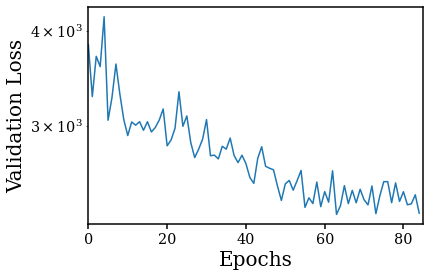

--- decoder [(4457, 3331, 12)] ---
--- encoder [(120, 40, 18)] ---
====> Epoch: 0 TRAINING Loss: 2.15e+03 VALIDATION Loss: 2.19e+03
====> Epoch: 20 TRAINING Loss: 2.08e+03 VALIDATION Loss: 2.13e+03
====> Epoch: 40 TRAINING Loss: 1.90e+03 VALIDATION Loss: 1.95e+03
====> Epoch: 60 TRAINING Loss: 1.85e+03 VALIDATION Loss: 1.90e+03
====> Epoch: 80 TRAINING Loss: 1.84e+03 VALIDATION Loss: 1.88e+03
====> Epoch: 100 TRAINING Loss: 1.83e+03 VALIDATION Loss: 1.88e+03
====> Epoch: 120 TRAINING Loss: 1.83e+03 VALIDATION Loss: 1.88e+03


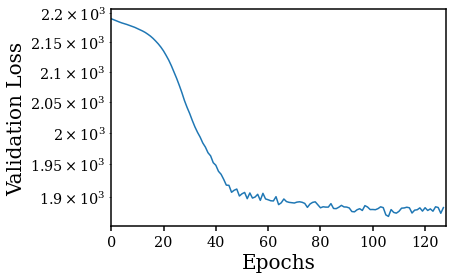

--- decoder [(4969, 233, 100)] ---
--- encoder [(183, 41, 34)] ---
====> Epoch: 0 TRAINING Loss: 2.14e+03 VALIDATION Loss: 2.19e+03
====> Epoch: 20 TRAINING Loss: 2.01e+03 VALIDATION Loss: 2.05e+03
====> Epoch: 40 TRAINING Loss: 1.85e+03 VALIDATION Loss: 1.89e+03
====> Epoch: 60 TRAINING Loss: 1.16e+03 VALIDATION Loss: 1.20e+03
====> Epoch: 80 TRAINING Loss: 1.05e+03 VALIDATION Loss: 1.09e+03
====> Epoch: 100 TRAINING Loss: 9.98e+02 VALIDATION Loss: 1.04e+03
====> Epoch: 120 TRAINING Loss: 9.24e+02 VALIDATION Loss: 9.52e+02
====> Epoch: 140 TRAINING Loss: 8.82e+02 VALIDATION Loss: 9.19e+02
====> Epoch: 160 TRAINING Loss: 8.38e+02 VALIDATION Loss: 8.67e+02
====> Epoch: 180 TRAINING Loss: 7.98e+02 VALIDATION Loss: 8.34e+02
====> Epoch: 200 TRAINING Loss: 7.56e+02 VALIDATION Loss: 8.05e+02
====> Epoch: 220 TRAINING Loss: 7.08e+02 VALIDATION Loss: 7.72e+02
====> Epoch: 240 TRAINING Loss: 6.47e+02 VALIDATION Loss: 7.13e+02
====> Epoch: 260 TRAINING Loss: 5.73e+02 VALIDATION Loss: 6.02e+02
=

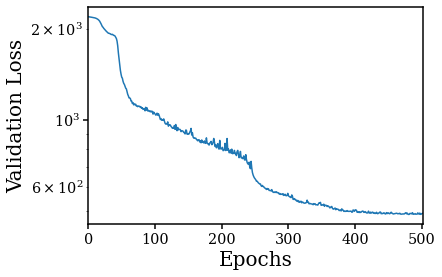

--- decoder [(5966, 208, 47)] ---
--- encoder [(45, 19, 9)] ---
====> Epoch: 0 TRAINING Loss: 2.16e+03 VALIDATION Loss: 2.20e+03
====> Epoch: 20 TRAINING Loss: 2.13e+03 VALIDATION Loss: 2.18e+03
====> Epoch: 40 TRAINING Loss: 1.98e+03 VALIDATION Loss: 2.04e+03
====> Epoch: 60 TRAINING Loss: 1.20e+03 VALIDATION Loss: 1.26e+03
====> Epoch: 80 TRAINING Loss: 1.07e+03 VALIDATION Loss: 1.13e+03
====> Epoch: 100 TRAINING Loss: 9.61e+02 VALIDATION Loss: 1.02e+03
====> Epoch: 120 TRAINING Loss: 8.77e+02 VALIDATION Loss: 9.41e+02
====> Epoch: 140 TRAINING Loss: 7.53e+02 VALIDATION Loss: 7.74e+02
====> Epoch: 160 TRAINING Loss: 7.05e+02 VALIDATION Loss: 7.31e+02
====> Epoch: 180 TRAINING Loss: 6.83e+02 VALIDATION Loss: 7.03e+02
====> Epoch: 200 TRAINING Loss: 6.74e+02 VALIDATION Loss: 7.17e+02
====> Epoch: 220 TRAINING Loss: 6.56e+02 VALIDATION Loss: 6.85e+02
====> Epoch: 240 TRAINING Loss: 6.48e+02 VALIDATION Loss: 6.74e+02
====> Epoch: 260 TRAINING Loss: 6.49e+02 VALIDATION Loss: 6.64e+02
====

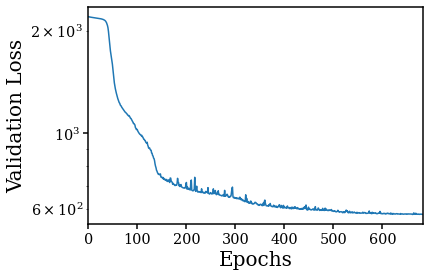

--- decoder [(879, 397, 122)] ---
--- encoder [(61, 37, 26)] ---
====> Epoch: 0 TRAINING Loss: 2.15e+03 VALIDATION Loss: 2.19e+03
====> Epoch: 20 TRAINING Loss: 2.11e+03 VALIDATION Loss: 2.16e+03
====> Epoch: 40 TRAINING Loss: 1.86e+03 VALIDATION Loss: 1.91e+03
====> Epoch: 60 TRAINING Loss: 1.84e+03 VALIDATION Loss: 1.89e+03
====> Epoch: 80 TRAINING Loss: 1.84e+03 VALIDATION Loss: 1.89e+03
====> Epoch: 100 TRAINING Loss: 1.83e+03 VALIDATION Loss: 1.89e+03
====> Epoch: 120 TRAINING Loss: 1.83e+03 VALIDATION Loss: 1.88e+03


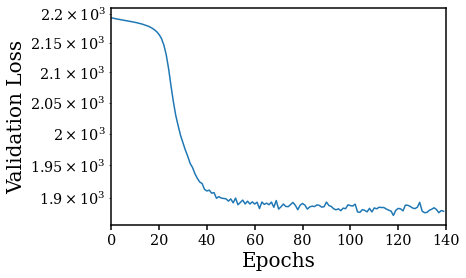

--- decoder [(5585, 1517, 72)] ---
--- encoder [(121, 84, 30)] ---
====> Epoch: 0 TRAINING Loss: 2.14e+03 VALIDATION Loss: 2.19e+03
====> Epoch: 20 TRAINING Loss: 1.93e+03 VALIDATION Loss: 1.98e+03
====> Epoch: 40 TRAINING Loss: 1.66e+03 VALIDATION Loss: 1.68e+03
====> Epoch: 60 TRAINING Loss: 1.13e+03 VALIDATION Loss: 1.17e+03
====> Epoch: 80 TRAINING Loss: 9.46e+02 VALIDATION Loss: 9.79e+02
====> Epoch: 100 TRAINING Loss: 8.10e+02 VALIDATION Loss: 8.48e+02
====> Epoch: 120 TRAINING Loss: 7.02e+02 VALIDATION Loss: 7.39e+02
====> Epoch: 140 TRAINING Loss: 6.65e+02 VALIDATION Loss: 6.88e+02
====> Epoch: 160 TRAINING Loss: 6.28e+02 VALIDATION Loss: 6.63e+02
====> Epoch: 180 TRAINING Loss: 6.10e+02 VALIDATION Loss: 6.49e+02
====> Epoch: 200 TRAINING Loss: 5.92e+02 VALIDATION Loss: 6.15e+02


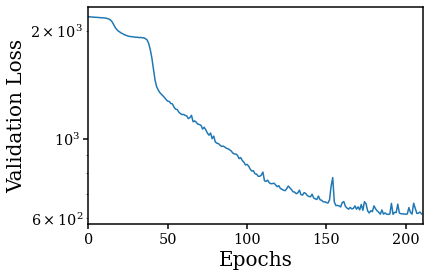

In [17]:
for i in range(10): 
    lambd = np.exp(np.random.uniform(0, np.log(1e5)))
    
    nhidden0 = int(np.ceil(np.exp(np.random.uniform(np.log(200), np.log(2*nwave)))))
    nhidden1 = int(np.ceil(np.exp(np.random.uniform(np.log(100), np.log(nhidden0)))))
    nhidden2 = int(np.ceil(np.exp(np.random.uniform(np.log(nlatent+1), np.log(nhidden1)))))
    print(f'--- decoder [{nhidden0, nhidden1, nhidden2}] ---')

    nkernels = [2,2,2]
    npools = [2,2,2]
    Nout = nwave - nkernels[0] + 1 
    Nout = int((Nout - npools[0])/npools[0] + 1)
    Nout = Nout - nkernels[1] + 1
    Nout = int((Nout - npools[1])/npools[1] + 1)
    Nout = Nout - nkernels[2] + 1
    Nout = int((Nout - npools[2])/npools[2] + 1)

    nhidden0_enc = int(np.ceil(np.exp(np.random.uniform(np.log(32), np.log(2*Nout)))))
    nhidden1_enc = int(np.ceil(np.exp(np.random.uniform(np.log(16), np.log(nhidden0_enc)))))
    nhidden2_enc = int(np.ceil(np.exp(np.random.uniform(np.log(nlatent+1), np.log(nhidden1_enc)))))
    print(f'--- encoder [{nhidden0_enc, nhidden1_enc, nhidden2_enc}] ---')  
    
    model = InfoVAE(
        alpha=0, 
        lambd=lambd, 
        nwave=nwave, 
        nkernels=nkernels, 
        npools=npools,
        nhiddens_enc=[nhidden0_enc, nhidden1_enc, nhidden2_enc], 
        nhiddens_dec=[nhidden0, nhidden1, nhidden2],
        ncode=5, 
        dropout=dropout)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps=n_epoch)

    best_valid_loss, best_epoch = 1e10, 0
    
    losses = []
    for epoch in range(n_epoch):
        model.train()
        train_loss = 0.
        for batch in train_loader:
            _ivar, _mask = batch
            _ivar = _ivar.to(device)
            _mask = _mask.to(device)
            
            optimizer.zero_grad()
            loss, _, _, _ = model.loss(_ivar, _mask)
            
            loss.backward()
            train_loss += loss.item() 
            optimizer.step()
        train_loss /= len(train_loader.dataset)
    
        with torch.no_grad():
            model.eval()
            valid_loss = 0.
            for batch in valid_loader:
                _ivar, _mask = batch
                _ivar = _ivar.to(device)
                _mask = _mask.to(device)
                
                loss, _, _, _ = model.loss(_ivar, _mask)
                valid_loss += loss.item()
            valid_loss /= len(valid_loader.dataset)

        scheduler.step()
        losses.append((train_loss, valid_loss))

        if epoch % 20 == 0 or epoch == n_epoch - 1:           
            print('====> Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % (epoch, train_loss, valid_loss))

        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_epoch = epoch
        else: 
            if epoch > best_epoch + 20: 
                break 

    # plot validation loss
    plt.plot(np.array(losses)[:,1])
    plt.yscale('log')
    plt.xlabel('Epochs', fontsize=20)
    plt.xlim(0, len(losses))
    plt.ylabel('Validation Loss', fontsize=20)
    plt.show()
    
    # save model to file 
    fmodel = os.path.join(dat_dir, f'ivar.vae_model.{i}.pt')
    torch.save(model.state_dict(), fmodel) 
    
    # save training/validation loss
    floss = os.path.join(dat_dir, f'ivar.vae_model.{i}.loss.npy')
    np.save(floss, np.array(losses))

select best model 

In [18]:
models, valid_losses = [], []
for i in range(10): 
    fmodel = os.path.join(dat_dir, f'ivar.vae_model.{i}.pt')
    state_dict = torch.load(fmodel) 
    
    model = InfoVAE(alpha=0, lambd=0, # these don't matter here
                    nwave=nwave,  
                    ncode=nlatent, 
                    nkernels=[state_dict['conv0.weight'].shape[-1], state_dict['conv1.weight'].shape[-1], state_dict['conv2.weight'].shape[-1]],
                    nhiddens_enc=[state_dict['enc0.weight'].shape[0], state_dict['enc1.weight'].shape[0], state_dict['enc2.weight'].shape[0]], 
                    nhiddens_dec=[state_dict['decd.weight'].shape[0], state_dict['decd2.weight'].shape[0], state_dict['decd3.weight'].shape[0]], 
                    dropout=dropout)
    model.load_state_dict(torch.load(fmodel))
    models.append(model)

    floss = os.path.join(dat_dir, f'ivar.vae_model.{i}.loss.npy')
    valid_losses.append(np.load(floss)[:,1])

best model: ivar.vae_model.9.pt


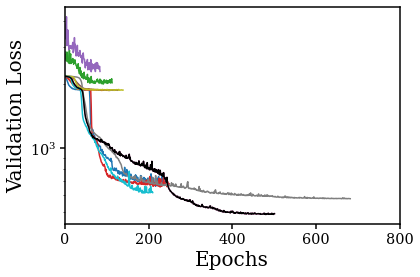

In [19]:
final_losses = np.array([_losses[-1] for _losses in valid_losses])
i_best = np.arange(len(final_losses))[np.isfinite(final_losses)][np.argmin(final_losses[np.isfinite(final_losses)])]
print(f'best model: ivar.vae_model.{i}.pt')

best_model = models[i_best]
best_model.to(device)

# plot validation losses
for _losses in valid_losses: 
    plt.plot(_losses)
plt.plot(valid_losses[i_best], c='k')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=20)
plt.xlim(0, 800)
plt.ylabel('Validation Loss', fontsize=20)
plt.show()

# 4. Validate best autoencoder

In [20]:
w_ivar_recon, _, _ = best_model.forward(torch.tensor(w_ivar[ntrain+nvalid:ntrain+nvalid+1000,None,:], dtype=torch.float32).to(device))

ivar_recon = (w_ivar_recon.detach().cpu().numpy() * std_ivar + avg_ivar) * ivar_norm[ntrain+nvalid:ntrain+nvalid+1000][:,None]

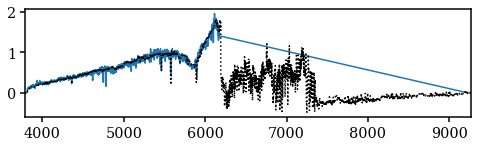

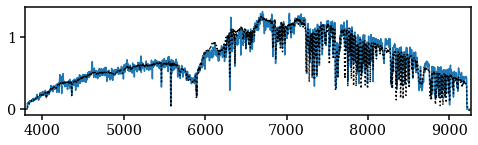

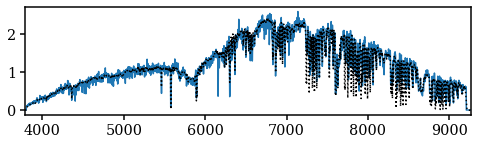

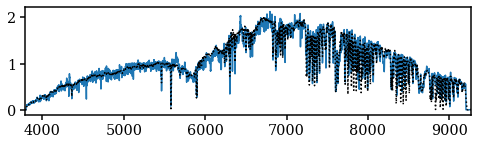

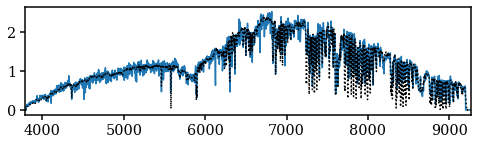

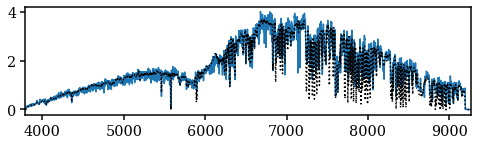

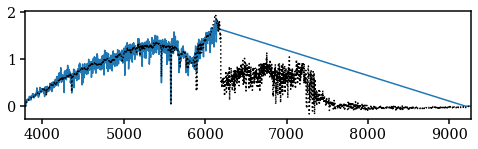

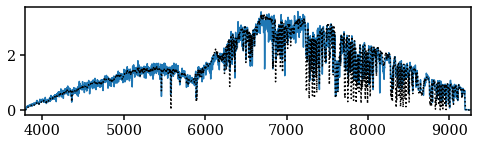

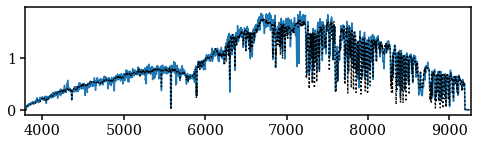

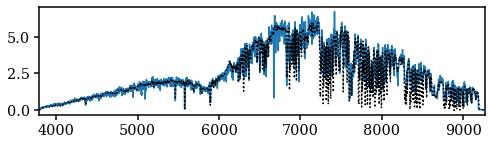

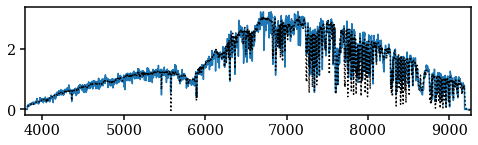

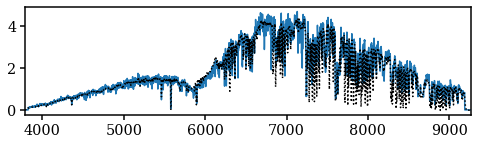

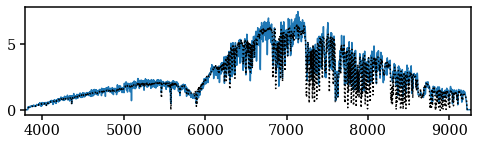

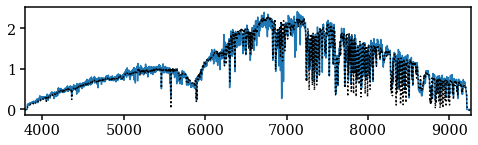

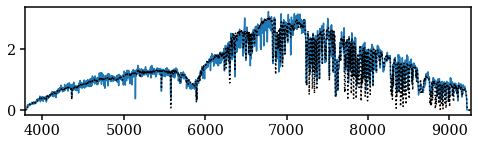

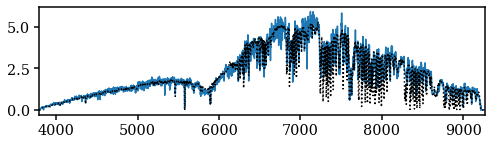

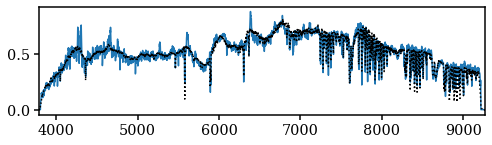

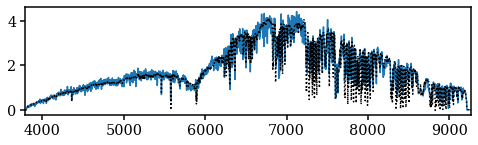

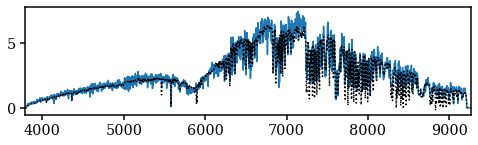

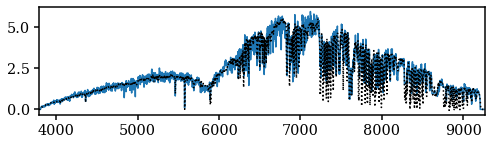

In [21]:
for i in range(20): 
    fig = plt.figure(figsize=(8,2))
    sub = fig.add_subplot(111)
    
    _mask = mask[ntrain+nvalid + 10 * i]
    sub.plot(wave[~_mask], ivar[ntrain+nvalid + 10 * i][~_mask])
    sub.plot(wave, ivar_recon[10 * i], c='k', ls=':')

    sub.set_xlim(wave[0], wave[-1])
    plt.show()

# 5. Compressed latent-space

In [22]:
_mu, _logvar = best_model.encode(torch.tensor(w_ivar[:,None,:], dtype=torch.float32).to(device))
h = best_model.reparameterize(_mu, _logvar).cpu().detach().numpy()

In [23]:
spec_norm = np.array([np.median(i[~m & ~iz]) for i, m, iz in zip(spec, mask, ivar_zero)])

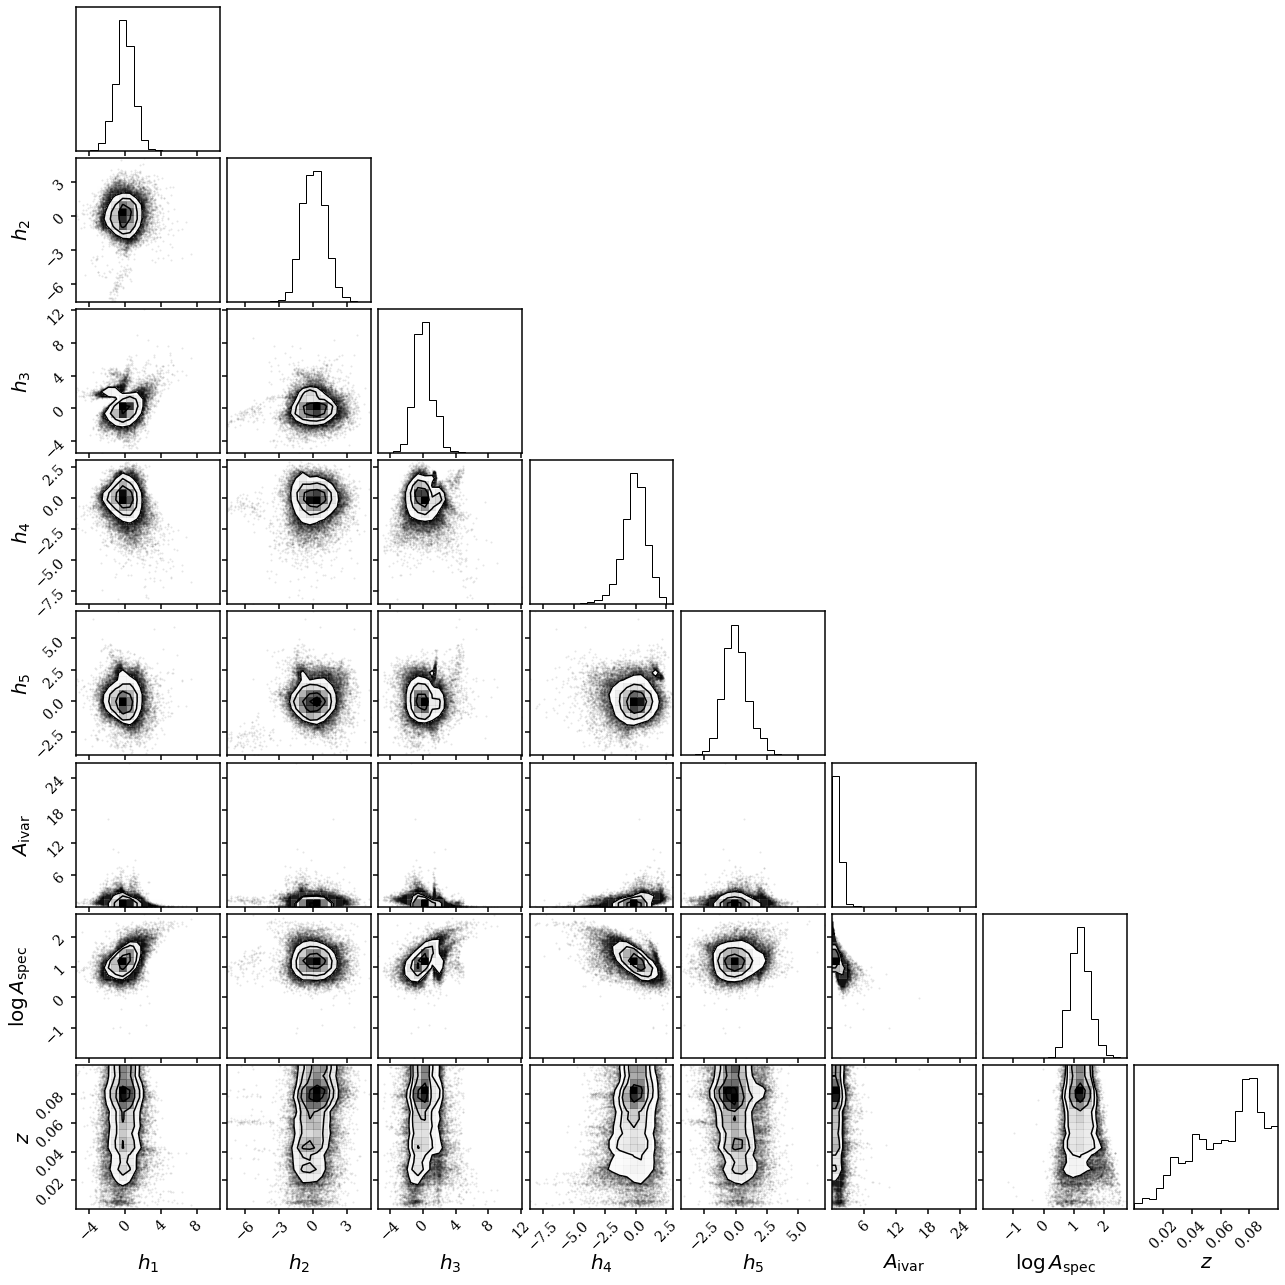

In [24]:
fig = DFM.corner(np.concatenate([h, 
                                 np.atleast_2d(ivar_norm).T, 
                                 np.atleast_2d(np.log10(spec_norm.clip(1e-2))).T,
                                 np.atleast_2d(zred).T],axis=1), 
                 labels=[r'$h_1$', r'$h_2$', r'$h_3$', r'$h_4$', r'$h_5$', r'$A_{\rm ivar}$', r'$\log A_{\rm spec}$', r'$z$'], 
                 label_kwargs={"fontsize": 20})

In [25]:
np.save(os.path.join(dat_dir, 'ivar.avg.npy'), avg_ivar)
np.save(os.path.join(dat_dir, 'ivar.std.npy'), std_ivar)

np.save(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.latvar.npy'), h)
np.save(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.ivar_norm.npy'), np.atleast_2d(ivar_norm).T)
np.save(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.spec_norm.npy'), np.atleast_2d(spec_norm).T)
np.save(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.zred.npy'), np.atleast_2d(zred).T)